In [1]:
from random import randrange
import pandas as pd
import numpy as np
import altair as alt
from sklearn.datasets import fetch_openml
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## Carregando os dados - MNIST
Descrição do site de onde os dados são baixados:

"The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples"

In [2]:
mnist = fetch_openml('mnist_784')

In [3]:
print("Tamanho do vetor de dados:", mnist.data.shape)
print("Tamanho do vetor de alvos:", mnist.target.shape)

Tamanho do vetor de dados: (70000, 784)
Tamanho do vetor de alvos: (70000,)


### Separando o conjunto de treino e teste
- Vale ressaltar que o ideal, para garantir a generalização do modelo, é separar o conjunto de treinamento em "K folds", realizando uma validação cruzada. Para diminuir o tempo de execução e simplificar este tutorial, dividiremos apenas em 2 folds
- Uma boa prática seria executar o algoritmo algumas vezes variando ambas as condições, calcular a média dos centróides encontrados e, por fim, usar esta média como os centróides iniciais da última execução
- O conjunto de teste (últimas 10000 entradas), segundo a fonte, foi gerado de maneira independente do conjunto de treino

In [4]:
n_train_samples = 10000
n_test_samples = 1000

In [5]:
X_train = mnist.data[0:n_train_samples]
y_train = mnist.target[0:n_train_samples]

X_test = mnist.data[60000:60000 + n_test_samples]
y_test = mnist.target[60000:60000 + n_test_samples]
y_test_int = y_test.astype(int)

### Visualizando uma amostra aleatória

In [6]:
def plot_digit(data, label = None):
    img = data.reshape(28,28)
    plt.figure()
    plt.imshow(img, cmap='gray', interpolation="nearest")
    if label is not None:
        plt.title("Label: %s" %label)
    plt.axis('off')

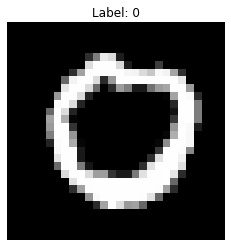

In [7]:
select = randrange(n_train_samples)
label = y_train[select]

plot_digit(X_train[select], label)

## Pré-processamento
- Aqui na rede ART, vamos experimentar escalar os valores dos pixels entre 0 e 1

In [8]:
#Scaling
X_train /= 255
X_test /= 255

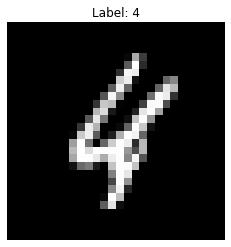

In [9]:
select = randrange(n_train_samples)
label = y_train[select]

plot_digit(X_train[select], label)

## Treinamento da ARTNet

In [10]:
from artnet import ARTNet

In [11]:
n_samples = 5000
artnet = ARTNet(similarity_radius=7, learning_rate=0.05)
np.unique(y_train[0:n_samples], return_counts=True)

(array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object),
 array([479, 563, 488, 493, 535, 434, 501, 550, 462, 495]))

In [12]:
artnet.fit(X_train[0:n_samples])

In [13]:
artnet.neurons.shape

(609, 784)

### Definindo algumas funções

In [14]:
def get_most_freq_digit(real_labels, predicted_labels, n_clusters):
    # criando uma lista com todos os IDs de clusters que foram previstos no conjunto de teste
    id_clusters = np.unique(predicted_labels)

    most_freq = np.zeros(n_clusters) # inicializando o vetor que conterá os dígitos mais frequentes em cada cluster
    for icluster in range(n_clusters):  
        # selecionando as labels das entradas que foram previstas como icluster
        labels = real_labels[predicted_labels==id_clusters[icluster]]
    
        # selecionando qual a label foi mais frequente para este cluster (icluster)
        most_freq[icluster] = np.argmax(np.bincount(labels))
    
    return most_freq


def calculate_accuracy(y_true, y_pred, most_freq):
    """
    Parameters
    ----------
    y_true : array_like
             List of expected values
    y_pred : array_like
             List of predicted values
    most_freq: array_like
               List containing the most frequent(or the predominant) labels for each cluster ID
                
    Returns
    -------
    float
        Returns calculated accuracy
    """
    
    # most_freq contains the most frequents digits in each cluster
    count = 0;
    for ievent in range(len(y_true)):
        cluster_predict = int(y_pred[ievent]) # prediction
        if int(y_true[ievent]) == int(most_freq[cluster_predict]):
            count += 1          
    accuracy = count/float(len(y_true))
    
    return accuracy

### Raio de similaridade

In [15]:
n_neurons = {}
accuracy = {}
for similarity_radius in np.arange(8, 11, 0.5):
    artnet = ARTNet(similarity_radius=similarity_radius, learning_rate=0.1)
    artnet.fit(X_train[0:n_samples])
    n_neurons[similarity_radius] = artnet.neurons.shape[0]
    
    predicted = artnet.predict(X_train[0:n_samples])
    most_freq = get_most_freq_digit(y_train[0:n_samples].astype(int),
                                    predicted,
                                    n_neurons[similarity_radius])
    
    accuracy_i = calculate_accuracy(y_train[0:n_samples], predicted, most_freq)
    
    accuracy[similarity_radius] = accuracy_i

In [16]:
n_neurons

{8.0: 143, 8.5: 54, 9.0: 29, 9.5: 17, 10.0: 8, 10.5: 4}

Apenas para fins didáticos, como será que a acurácia varia com esses raios?

### Acurácia

In [17]:
accuracy

{8.0: 0.0604, 8.5: 0.0232, 9.0: 0.058, 9.5: 0.0212, 10.0: 0.0396, 10.5: 0.0578}

- Essa métrica não existiria para qualquer dataset essencialmente não supervisionado
- Nesse caso, definimos um "acerto" como um dígito classificado de acordo com o mais frequente naquele cluster (neurônio). Porém, a rede está sendo treinada para agrupá-los por similaridade, de acordo com a cor dos pixels. Pode ser que haja casos de dígitos diferentes que são "similares" segundo os dados que a rede tem conhecimento.

### Escolha do raio de similaridade

In [18]:
chosen_sr = 9

In [19]:
artnet = ARTNet(similarity_radius=chosen_sr, learning_rate=0.1)
artnet.fit(X_train[1:5000])

In [20]:
artnet.neurons.shape

(27, 784)

In [21]:
X_train_predicted = artnet.predict(X_train[1:])
np.unique(X_train_predicted, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 array([  25,  524,    7, 1241, 1293, 1075,  342,  808,    9,  541,   87,
         331,  349,  420,  131,  953,  247,  718,    1,  637,    4,  231,
           2,    4,    2,    7,    2,    8]))

In [22]:
cluster_id = 20

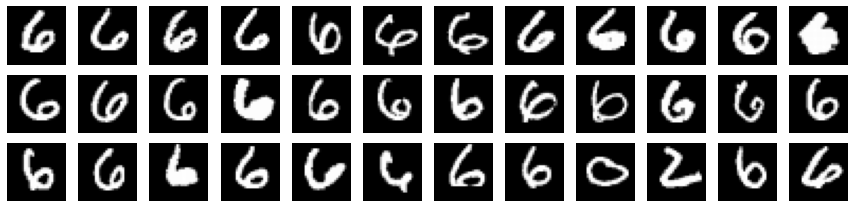

In [23]:
num_row = 3
num_col = 12
num= num_row*num_col

cluster_data = X_train[1:][np.array(X_train_predicted) == cluster_id]
fig, axes = plt.subplots(num_row, num_col, figsize=(num_col,num_row))

for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(cluster_data[i].reshape(28,28), cmap='gray')
    ax.axis('off')
    
plt.tight_layout()
plt.show()

### Plotando os pesos dos neurônios

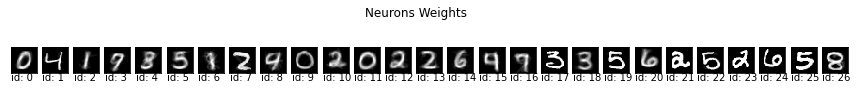

In [24]:
nrows = 1
ncols = artnet.neurons.shape[0]
irow = 0
icolumn = 0

fig, ax = plt.subplots(figsize=(15,3),nrows=nrows, ncols=ncols)

for cluster in range(ncols):
    img = artnet.neurons[cluster];
    img = img.reshape(28,28);

    ax[icolumn].imshow(img, cmap='gray', interpolation="nearest")
    ax[icolumn].text(0, 35, 'id: %s' % cluster)
    
    ax[icolumn].get_xaxis().set_visible(False)
    ax[icolumn].get_yaxis().set_visible(False)
    
    icolumn = icolumn + 1

plt.suptitle('Neurons Weights', y=0.75);